In [1]:
import os
import cv2
import pickle
import numpy as np
import pdb
import requests
from collections import defaultdict
import random 
import time
import matplotlib.pyplot as plt 

from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import f1_score, accuracy_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier


from tqdm import *

from functools import wraps
from time import time as _timenow 
from sys import stderr

import keras
from keras.models import Sequential
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.datasets import cifar10
from keras import regularizers
from keras.callbacks import LearningRateScheduler
from keras.datasets import cifar10 





/home/sushmitha/tmp/new/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/home/sushmitha/tmp/new/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Load CIFAR-10 Data

In [3]:
def unpickle(file):
    with open(file, 'rb') as fo:
        data = pickle.load(fo, encoding='latin1')
    return data

In [4]:
def load_cifar():
    
    trn_data, trn_labels, tst_data, tst_labels = [], [], [], []
    
    for i in trange(1):
        batchName = './data/data_batch_{0}'.format(i + 1)
        unpickled = unpickle(batchName)
        trn_data.extend(unpickled['data'])
        trn_labels.extend(unpickled['labels'])
    unpickled = unpickle('./data/test_batch')
    tst_data.extend(unpickled['data'])
    tst_labels.extend(unpickled['labels'])
    return trn_data, trn_labels, tst_data, tst_labels


## Image preprocessing

In [5]:
def image_prep(train, test):
    ''' pre-processes the given image
        performs mean normalization and other such operations'''

    scaler = preprocessing.StandardScaler().fit(train)
    train_data = scaler.transform(train)
    test_data = scaler.transform(test)
    
    return train_data, test_data

## Dimensionality reduction using PCA

In [10]:
def reduce_dim(**kwargs):
    ''' performs dimensionality reduction'''
    if kwargs['method'] == 'pca':
        pca = PCA(n_components=kwargs['no_of_comp'])
        pca = pca.fit(kwargs['train'])
        train_new = pca.transform(kwargs['train'])
        test_new = pca.transform(kwargs['test'])
        return train_new, test_new
    elif kwargs['method'] == 'lda':
        clf = LinearDiscriminantAnalysis(n_components=600)
        clf = clf.fit(kwargs['train'], kwargs['train_label'])
        train_new = clf.transform(kwargs['train'])
        test_new = clf.transform(kwargs['test'])
        return train_new, test_new

## Classification using kernel SVM

In [11]:
def classify(X, y, **kwargs):
#     n_estimators is number of trees in the forest.
#     min_samples_split is minimum number of samples required to split an internal node
    if kwargs['method'] == 'CART':
        model = RandomForestClassifier(n_estimators=kwargs['num_trees'], min_samples_split=kwargs['min_samples_split'], bootstrap=True)
        model = model.fit(X, y)
        return model
    else:
        pass

## Evaluation 

In [12]:
def evaluate(target, predicted):
    f1 = f1_score(target, predicted, average='micro')
    acc = accuracy_score(target, predicted)
    return f1, acc

In [17]:
def test(**kwargs):
    if kwargs['method'] == 'CART':
        model = kwargs['model']
        X_test = kwargs['test']
        predictions = model.predict(X_test)
        
        return predictions

In [20]:
def find_n_estimators(): 
    num_trees_arr=[]
    acc=[]
    i=50
    trn_data, trn_labels, tst_data, tst_labels = load_cifar()
    X_train, X_test, y_train, y_test = train_test_split(trn_data, trn_labels,test_size = 0.20) 
    while(i<420):
        trn_data, tst_data = image_prep(X_train, X_test)
        model = classify(trn_data, y_train, num_trees=i, min_samples_split=5, method='CART')
        output = test(test = tst_data, model= model, method='CART')
        f_score, accuracy = evaluate(y_test, output)
        print('Val - F1 score: {}\n Accuracy: {}'.format(f_score, accuracy))
        acc.append(accuracy)
        num_trees_arr.append(i)
        
        i+=50
        
        
    return acc, num_trees_arr

100%|██████████| 1/1 [00:00<00:00, 49.85it/s]


Val - F1 score: 0.3985
 Accuracy: 0.3985
Val - F1 score: 0.4195
 Accuracy: 0.4195
Val - F1 score: 0.4285
 Accuracy: 0.4285
Val - F1 score: 0.433
 Accuracy: 0.433
Val - F1 score: 0.4405
 Accuracy: 0.4405
Val - F1 score: 0.445
 Accuracy: 0.445
Val - F1 score: 0.439
 Accuracy: 0.439
Val - F1 score: 0.435
 Accuracy: 0.435


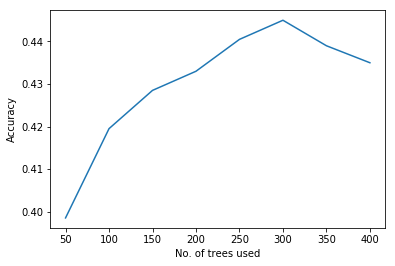

In [21]:
acc, num_trees_arr = find_n_estimators()
plt.plot(num_trees_arr, acc)
plt.xlabel('No. of trees used') 
plt.ylabel('Accuracy') 
plt.show()

In [26]:
def find_num_pca_components():
    i=50
    acc=[]
    x_axis=[]
    trn_data, trn_labels, tst_data, tst_labels = load_cifar()
    X_train, X_test, y_train, y_test = train_test_split(trn_data, trn_labels,test_size = 0.20)
    while(i<250):
        trn_data, tst_data = image_prep(X_train, X_test)
        trn_data, tst_data = reduce_dim(train=trn_data, test=tst_data, train_label=y_train,method='pca',no_of_comp=i)
        model = classify(trn_data, y_train, num_trees=300, min_samples_split=5, method='CART')
        output = test(test = tst_data, model= model, method='CART')
        f_score, accuracy = evaluate(y_test, output)
        print('Val - F1 score: {}\n Accuracy: {}'.format(f_score, accuracy))
        acc.append(accuracy)
        x_axis.append(i)
        i+=10
    return acc, x_axis

100%|██████████| 1/1 [00:00<00:00, 43.18it/s]


Val - F1 score: 0.4425
 Accuracy: 0.4425
Val - F1 score: 0.44
 Accuracy: 0.44
Val - F1 score: 0.4475
 Accuracy: 0.4475
Val - F1 score: 0.4535
 Accuracy: 0.4535
Val - F1 score: 0.439
 Accuracy: 0.439
Val - F1 score: 0.43849999999999995
 Accuracy: 0.4385
Val - F1 score: 0.451
 Accuracy: 0.451
Val - F1 score: 0.4405
 Accuracy: 0.4405
Val - F1 score: 0.439
 Accuracy: 0.439
Val - F1 score: 0.451
 Accuracy: 0.451
Val - F1 score: 0.436
 Accuracy: 0.436
Val - F1 score: 0.439
 Accuracy: 0.439
Val - F1 score: 0.4515
 Accuracy: 0.4515
Val - F1 score: 0.433
 Accuracy: 0.433
Val - F1 score: 0.4345
 Accuracy: 0.4345
Val - F1 score: 0.4255
 Accuracy: 0.4255
Val - F1 score: 0.4305
 Accuracy: 0.4305
Val - F1 score: 0.419
 Accuracy: 0.419
Val - F1 score: 0.422
 Accuracy: 0.422
Val - F1 score: 0.411
 Accuracy: 0.411


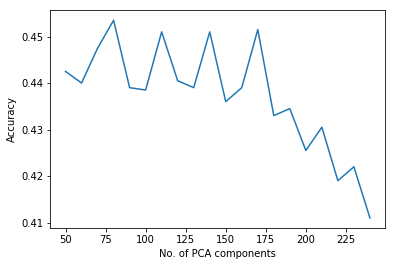

In [27]:
acc, x_axis = find_num_pca_components()
plt.plot(x_axis, acc)
plt.xlabel('No. of PCA components') 
plt.ylabel('Accuracy') 
plt.show()

In [30]:
def find_min_samples_split():
    i=2
    acc=[]
    x_axis=[]
    trn_data, trn_labels, tst_data, tst_labels = load_cifar()
    X_train, X_test, y_train, y_test = train_test_split(trn_data, trn_labels,test_size = 0.20) 
    while i<10:
        trn_data, tst_data = image_prep(X_train, X_test)
        trn_data, tst_data = reduce_dim(train=trn_data, test=tst_data, train_label=y_train,method='pca',no_of_comp=80)
        model = classify(trn_data, y_train, num_trees=300, min_samples_split=i, method='CART')
        output = test(test = tst_data, model= model, method='CART')
        f_score, accuracy = evaluate(y_test, output)
        print('Val - F1 score: {}\n Accuracy: {}'.format(f_score, accuracy))
        acc.append(accuracy)
        x_axis.append(i)
        i+=1
    return acc, x_axis

100%|██████████| 1/1 [00:00<00:00, 47.88it/s]


Val - F1 score: 0.4405
 Accuracy: 0.4405
Val - F1 score: 0.4565000000000001
 Accuracy: 0.4565
Val - F1 score: 0.449
 Accuracy: 0.449
Val - F1 score: 0.464
 Accuracy: 0.464
Val - F1 score: 0.4535
 Accuracy: 0.4535
Val - F1 score: 0.443
 Accuracy: 0.443
Val - F1 score: 0.4505
 Accuracy: 0.4505
Val - F1 score: 0.445
 Accuracy: 0.445


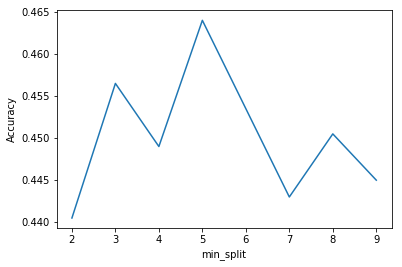

In [31]:
acc, x_axis = find_min_samples_split()
plt.plot(x_axis, acc)
plt.xlabel('min_split') 
plt.ylabel('Accuracy') 
plt.show()

In [32]:
trn_data, trn_labels, tst_data, tst_labels = load_cifar()
X_train, X_test, y_train, y_test = train_test_split(trn_data, trn_labels, test_size = 0.20)

100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


In [35]:
# running on raw data

trn_data, tst_data = image_prep(X_train, tst_data)
model = classify(trn_data, y_train, num_trees=300, min_samples_split=5, method='CART')
output = test(test = tst_data, model= model, method='CART')
f_score, accuracy = evaluate(tst_labels, output)
print('Val - F1 score: {}\n Accuracy: {}'.format(f_score, accuracy))

100%|██████████| 1/1 [00:00<00:00,  1.30it/s]


Val - F1 score: 0.4271
 Accuracy: 0.4271


In [36]:
# PCA reduction

trn_data, trn_labels, tst_data, tst_labels = load_cifar()
X_train, X_test, y_train, y_test = train_test_split(trn_data, trn_labels, test_size = 0.20)

trn_data, tst_data = image_prep(X_train, tst_data)
trn_data, tst_data = reduce_dim(train=trn_data, test=tst_data, train_label=y_train, method='pca',no_of_comp=80)
model = classify(trn_data, y_train, num_trees=300, min_samples_split=5, method='CART')
output = test(test = tst_data, model= model, method='CART')
f_score, accuracy = evaluate(tst_labels, output)
print('Val - F1 score: {}\n Accuracy: {}'.format(f_score, accuracy))

100%|██████████| 1/1 [00:00<00:00, 19.60it/s]


Val - F1 score: 0.4423
 Accuracy: 0.4423


In [37]:
#  data reduction with LDA

trn_data, trn_labels, tst_data, tst_labels = load_cifar()
X_train, X_test, y_train, y_test = train_test_split(trn_data, trn_labels, test_size = 0.20)

trn_data, tst_data = image_prep(X_train, tst_data)
trn_data, tst_data = reduce_dim(train=trn_data, test=tst_data, train_label=y_train, method='lda',no_of_comp=700)
model = classify(trn_data, y_train, num_trees=300, min_samples_split=5, method='CART')
output = test(test = tst_data, model= model, method='CART')
f_score, accuracy = evaluate(tst_labels, output)
print('Val - F1 score: {}\n Accuracy: {}'.format(f_score, accuracy))

100%|██████████| 1/1 [00:00<00:00, 31.33it/s]


Val - F1 score: 0.2397
 Accuracy: 0.2397
